In [2]:
# basic libraries
import math
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# torch libraries
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torch import nn
from torch_snippets import Report


In [3]:
root_path = "images_mo434/"

fish_types = {
              'Black Sea Sprat': '000',
              'Gilt-Head Bream': '001', #x.JPG
              'Hourse Mackerel': '002',
              'Red Mullet': '003',
              'Red Sea Bream': '004', #100-146x.JPG
              'Sea Bass': '005', #x.JPG
              'Shrimp': '006',
              'Striped Red Mullet': '007',
              'Trout': '008'
              }

# Preparing dataset

In [4]:
fish_path = root_path + "old_fish/"
img_paths = [fish_path+x for x in os.listdir(fish_path)]

In [5]:
# originally images have 1024x768
xsize = 224 # pixels
ysize = 224
nchannels = 3
maxval = 255 # pixel value

# percentages of samples to split
train_perc = 0.3
valid_perc = 0.3
test_perc = 0.4

In [6]:
num_train_samples = int(len(img_paths)*train_perc)
num_valid_samples = int(len(img_paths)*valid_perc)
num_test_samples = int(len(img_paths)*test_perc)

np.random.shuffle(img_paths)

train_set = img_paths[:num_train_samples]
valid_set = img_paths[num_train_samples:num_train_samples+num_valid_samples]
test_set = img_paths[num_train_samples+num_valid_samples:]

In [7]:
# rgb_values = np.concatenate(
#     [Image.open(img).getdata() for img in img_paths], 
#     axis=0
# ) / 255.

# mean_val_pixel = np.mean(rgb_values, axis=0)  # mu_rgb.shape == (3,)
# std_val_pixel = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)

#calculate this takes too long, so I wrote the result here:
mean_val_pixels = (0.420,0.424,0.460)
std_val_pixels = (0.230, 0.174 ,0.160)

print(f"Mean value of pixels: {mean_val_pixels}\nStandard deviation of pixels values: {std_val_pixels}")

Mean value of pixels: (0.42, 0.424, 0.46)
Standard deviation of pixels values: (0.23, 0.174, 0.16)


In [8]:
# defining device
gpu = torch.cuda.is_available()
device = torch.device(0) if gpu else torch.device('cpu')

# PAIRWAISE COMPARISON

In [10]:
import re
from torch_snippets import fname, parent, Glob, choose, read, Dataset, optim, F, show
import torchvision
plt.style.use('dark_background')

In [11]:
# train_set.extend(valid_set)

for train_img in train_set:
    os.system("cp -r "+train_img+" images_mo434/train_fish_comp/")

for val_img in valid_set:
    os.system("cp -r "+val_img+" images_mo434/val_fish_comp/")

for test_img in test_set:
    os.system("cp -r "+test_img+" images_mo434/test_fish_comp/")

In [12]:
# creating dataset with pairs

class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob('{}'.format(self.folder))
        self.transform = transform
    
    def __getitem__(self, ix):

        itemA = self.items[ix]
        fishA = re.split('_',fname((itemA)))[0]
        itemB = choose(self.items)
        fishB = re.split('_',fname((itemB)))[0]
        
        same_fish = int(fishA==fishB)

        imgA = Image.open(itemA) # when using read(), it was b&w
        imgB = Image.open(itemB)

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
            
        return imgA, imgB, np.array([same_fish])
    
    def __len__(self):
        return len(self.items)


In [14]:
# defining transforms

train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9, 1.1)),
    transforms.Resize((xsize,ysize),interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean_val_pixels, std_val_pixels)
])

val_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((xsize, ysize)),
    transforms.ToTensor(),
    transforms.Normalize(mean_val_pixels, std_val_pixels)
])

test_transform = val_transform

In [15]:
# dataloaders for train and validation
train_dataset = SiameseNetworkDataset(folder='images_mo434/train_fish_comp', transform=train_transform)
test_dataset = SiameseNetworkDataset(folder='images_mo434/test_fish_comp', transform=val_transform)
valid_dataset = SiameseNetworkDataset(folder='images_mo434/val_fish_comp', transform=val_transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=32)
valid_dataloader = DataLoader(valid_dataset, shuffle=True, batch_size=32)


In [16]:
def conv_block(nchannels_in, nchannels_out):
    return nn.Sequential(
        nn.Conv2d(nchannels_in, nchannels_out, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(nchannels_out),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [17]:
# Network architecture

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            conv_block(3,32),
            conv_block(32,128),
            conv_block(128,256),
            nn.Flatten(),
            nn.Linear(in_features=int(256*xsize*ysize/(4*4*4)), out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 9)
        )
    
    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [18]:
contrastive_thr = 1.1
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        pair_dist = nn.PairwiseDistance(keepdim=True)
        euclidean_distance = pair_dist(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
                                       label * torch.pow(torch.clamp(self.margin-euclidean_distance, min=0.0),2))/2
        acc = ((euclidean_distance > contrastive_thr) == label).float().mean()
        return loss_contrastive, acc

In [19]:
# train and val functions

def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc =  criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc =  criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

def Test(model, testload, criterion):
    N = len(testload)
    all_loss = []
    all_acc = []
    for bx, data in enumerate(testload):
        loss, acc = validate_batch(model, data, criterion)
        all_loss.append(loss)
        all_acc.append(acc)

    mean_loss = np.mean(all_loss)
    mean_acc = np.mean(all_acc)
    std_loss = np.std(all_loss)
    std_acc = np.std(all_acc)
    return (mean_loss, std_loss, mean_acc, std_acc)

In [20]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [21]:
# Train and evaluate
n_epochs = 50
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    for i, data in enumerate(valid_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)

EPOCH: 20.000  val_loss: 0.581  val_acc: 0.362  trn_loss: 0.559  trn_acc: 0.284  (831.60s - 1247.40s remaining)
EPOCH: 40.000  val_loss: 0.433  val_acc: 0.455  trn_loss: 0.566  trn_acc: 0.337  (1661.16s - 415.29s remaining)
EPOCH: 50.000  val_loss: 0.253  val_acc: 0.615  (2079.64s - 0.00s remaining)))

100%|██████████| 151/151 [00:00<00:00, 9024.12it/s]

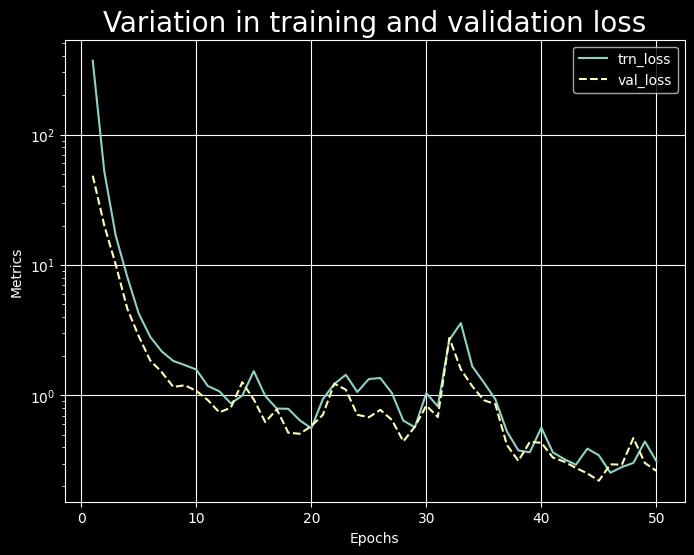

100%|██████████| 151/151 [00:00<00:00, 8119.33it/s]


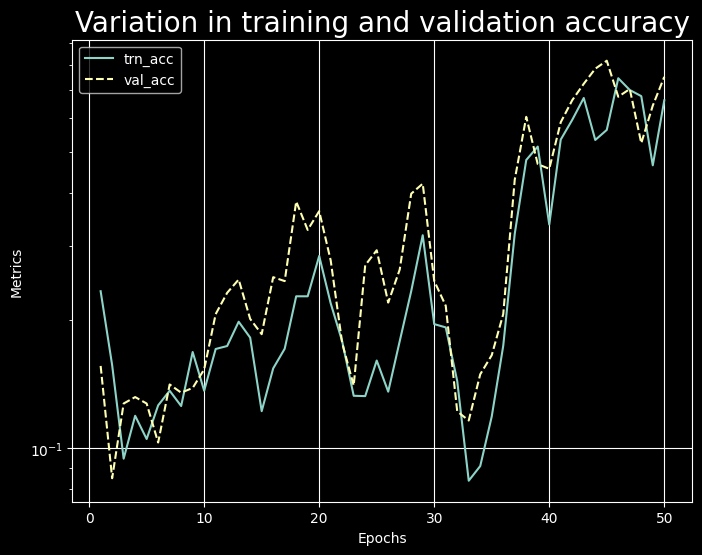

In [22]:
# plotting results 
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title="Variation in training and validation loss")
log.plot_epochs(['trn_acc', 'val_acc'], log=True, title="Variation in training and validation accuracy")

In [23]:
# SAVING
torch.save(model.state_dict(), 'dict_pairwise.pth')
torch.save(model, 'pairwise.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


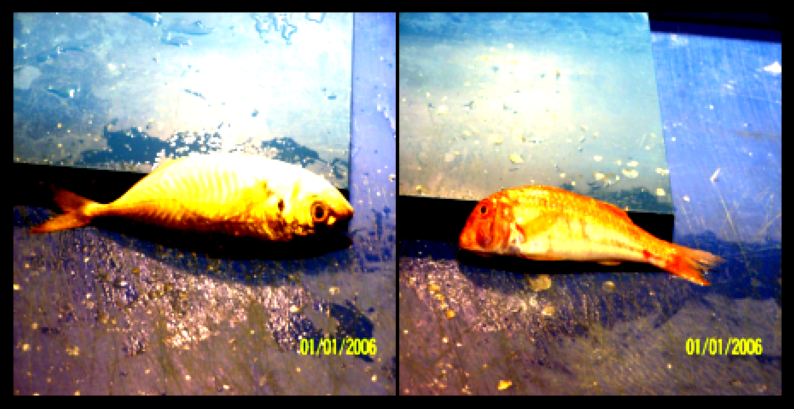

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


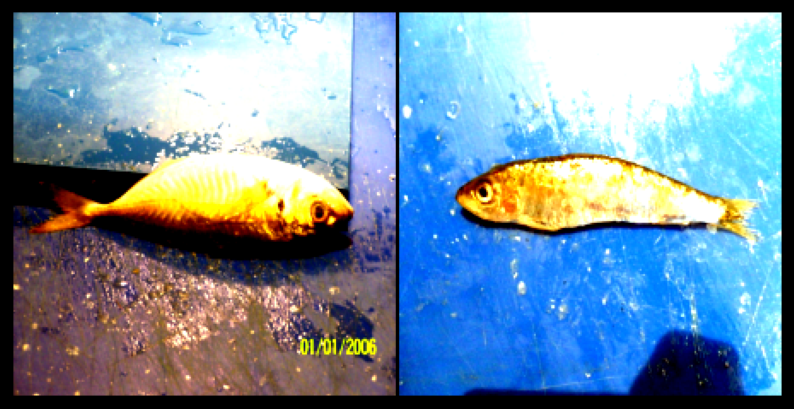

In [26]:
model.eval()
val_dl = DataLoader(valid_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(val_dl)
x0, _, label1 = next(dataiter)

for i in range(2):
    _, x1, _ = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5), 0)
    output1, output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = nn.PairwiseDistance()(output1, output2)
    output = 'Same Fish' if euclidean_distance.item()<= contrastive_thr else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}\nTrue label:{}'.format(
             euclidean_distance.item(), output))
    plt.show

# Test (metrics)

In [28]:
import pandas as pd
mean_loss, std_loss, mean_acc, std_acc = Test(model,test_dataloader, criterion)


In [29]:
df = pd.DataFrame(columns=['Loss mean', 'Loss std', 'Accuracy mean', 'Accuracy std'])
df.loc[len(df)] = [mean_loss, std_loss, mean_acc, std_acc]
df

,Loss mean,Loss std,Accuracy mean,Accuracy std
0,0.292722,0.031386,0.731206,0.042557


# Load and use on new weights from contrastive on CNN

In [30]:
# New test set

class ImageDataSet():

    def __init__(self, dataset, transform=None):
        self.dataset = dataset # list of image paths
        self.targets = [int(str(x).split("/")[-1].split("_")[0]) for x in self.dataset]
        self.transform = transform

    def __len__(self): 
        return len(self.dataset)

    def __getitem__(self, ix): #ix is the position
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image, target)

def GetBatches(dataset, batchsize, transformation):
    datatensor = ImageDataSet(dataset, transformation)
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return dataloader

batchsize = 32

testload  = GetBatches(test_set, batchsize, val_transform) 

In [31]:
# Network architecture

class SiameseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SiameseClassifier, self).__init__()
        self.features = nn.Sequential(
            conv_block(3,32),
            conv_block(32,128),
            conv_block(128,256),
            nn.Flatten(),
            nn.Linear(in_features=int(256*xsize*ysize/(4*4*4)), out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, input):
        return self.features(input)

In [32]:
model = SiameseClassifier(9)
model.load_state_dict(torch.load('dict_pairwise.pth'))

<All keys matched successfully>

In [33]:
# changing criterion
def criterion(preds, targets):
    cross_ent = nn.CrossEntropyLoss().to(device)
    loss = cross_ent(preds, targets.long())
    pred_labels = torch.max(preds,1)[1] #argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    return loss, acc

In [34]:
# Evaluate

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()

def Test(model, testload, criterion, device):
    N = len(testload)
    all_loss = []
    all_acc = []
    for bx, data in enumerate(testload):
        loss, acc = validate_batch(model, data, criterion, device)
        all_loss.append(loss)
        all_acc.append(acc)

    mean_loss = np.mean(all_loss)
    mean_acc = np.mean(all_acc)
    std_loss = np.std(all_loss)
    std_acc = np.std(all_acc)
    return (mean_loss, std_loss, mean_acc, std_acc)

In [35]:
device='cpu'
mean_loss, std_loss, mean_acc, std_acc = Test(model,testload, criterion, device)
df = pd.DataFrame(columns=['Loss mean', 'Loss std', 'Accuracy mean', 'Accuracy std'])
df.loc[len(df)] = [mean_loss, std_loss, mean_acc, std_acc]
df

,Loss mean,Loss std,Accuracy mean,Accuracy std
0,2.900242,0.177777,0.057292,0.055365


In [41]:
from sklearn.metrics import cohen_kappa_score
def Test_per_class(model, testload, device):

    kappa = []
    acc = []

    for _, data in enumerate(testload):
        # take original data
        ims, target = data
        ims = ims.to(device=device)
        target = target.to(device=device)
        # run model to see predicted
        preds = model(ims)
        pred_labels = torch.max(preds, 1)[1] #same as argmax
        # calculate accurancy and cohens kappa
        for val_target, val_pred in zip(target.tolist(),pred_labels.tolist()):
            accur = int(val_target==val_pred)
            acc.append(accur)
            kappa.append(cohen_kappa_score(np.array([val_target]), np.array([val_pred])))
    

    kappa = [1 if math.isnan(x) else x for x in kappa]
    mean_kappa = np.mean(kappa)
    mean_acc = np.mean(acc)
    std_kappa = np.std(kappa)
    std_acc = np.std(acc)

    return ([mean_kappa, std_kappa, mean_acc, std_acc])

In [42]:
# MELHOR TESTAR INPUTANDO SÓ UMA CLASSE
testset0 = [x for x in test_set if "000_" in x]
testload0  = GetBatches(testset0, batchsize, val_transform) 
testset1 = [x for x in test_set if "001_" in x]
testload1  = GetBatches(testset1, batchsize, val_transform) 
testset2 = [x for x in test_set if "002_" in x]
testload2  = GetBatches(testset2, batchsize, val_transform) 
testset3 = [x for x in test_set if "003_" in x]
testload3  = GetBatches(testset3, batchsize, val_transform) 
testset4 = [x for x in test_set if "004_" in x]
testload4  = GetBatches(testset4, batchsize, val_transform) 
testset5 = [x for x in test_set if "005_" in x]
testload5  = GetBatches(testset5, batchsize, val_transform) 
testset6 = [x for x in test_set if "006_" in x]
testload6  = GetBatches(testset6, batchsize, val_transform)
testset7 = [x for x in test_set if "007_" in x]
testload7  = GetBatches(testset7, batchsize, val_transform)
testset8 = [x for x in test_set if "008_" in x]
testload8  = GetBatches(testset8, batchsize, val_transform) 

In [ ]:

m0 = Test_per_class(model, testload0, device)
m1 = Test_per_class(model, testload1, device)
m2 = Test_per_class(model, testload2, device)
m3 = Test_per_class(model, testload3, device)
m4 = Test_per_class(model, testload4, device)
m5 = Test_per_class(model, testload5, device)
m6 = Test_per_class(model, testload6, device)
m7 = Test_per_class(model, testload7, device)
m8 = Test_per_class(model, testload8, device)

/home/c97818a/esg_venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/c97818a/esg_venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/c97818a/esg_venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/c97818a/esg_venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/c97818a/esg_venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars

In [ ]:
df_metrics = pd.DataFrame(columns=['Mean kappa', 'Std kappa', 'Mean accuracy', 'Std accuracy'])
df_metrics.loc[len(df_metrics)] = m0
df_metrics.loc[len(df_metrics)] = m1
df_metrics.loc[len(df_metrics)] = m2
df_metrics.loc[len(df_metrics)] = m3
df_metrics.loc[len(df_metrics)] = m4
df_metrics.loc[len(df_metrics)] = m5
df_metrics.loc[len(df_metrics)] = m6
df_metrics.loc[len(df_metrics)] = m7
df_metrics.loc[len(df_metrics)] = m8


In [ ]:
fish_numbers = {
              0:'Black Sea Sprat',
              1:'Gilt-Head Bream', 
              2:'Hourse Mackerel',
              3:'Red Mullet',
              4:'Red Sea Bream', 
              5:'Sea Bass',
              6:'Shrimp',
              7:'Striped Red Mullet',
              8:'Trout'
              }
df_metrics['Fish class']=[fish_numbers[i] for i in range(len(df_metrics))]
df_metrics

,Mean kappa,Std kappa,Mean accuracy,Std accuracy,Fish class
0,0.000000,0.000000,0.000000,0.000000,Black Sea Sprat
1,0.000000,0.000000,0.000000,0.000000,Gilt-Head Bream
2,0.842105,0.364642,0.842105,0.364642,Hourse Mackerel
3,0.000000,0.000000,0.000000,0.000000,Red Mullet
4,0.000000,0.000000,0.000000,0.000000,Red Sea Bream
5,0.000000,0.000000,0.000000,0.000000,Sea Bass
6,0.000000,0.000000,0.000000,0.000000,Shrimp
7,0.000000,0.000000,0.000000,0.000000,Striped Red Mullet
8,0.000000,0.000000,0.000000,0.000000,Trout
